**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

## Machine Learning Algorithms comparison: Support Vector Machine vs Random Forest

## Warning
Please, do not use the options to run all the cells together, because some cells contains the training methods for the algorithm and they require quite a long time to compute (usually more than 2 hours each). The results of the training are always included after these cells and before each cell of this type there is this warning:  

"The following cell contains the parameters tuning algorithm: do not execute it!"

### Abstract

This notebook analyzes two different machine learning algorithms and a deep neural network.
1. SVM - Support Vector Machine
2. RF - Random Forest

After a brief introduction, when the existing data will be presented, the notebook shows some techniques to visualize and clean up data before feeding them to the machine learning algorithms. Both algorithms use the same dataset and the same training approach. The model is indeed trained using the train data and the train label: the accuracy of the training is then calculated using the predicted labels and the training labels. Finally, the final predictions are exported in a csv file, to be uploaded into kaggle.

### 1. Introduction

#### Support Vector Machine
Support Vector Machine is a supervised model used for classification and regression analysis. Each data point z is viewed as a p-dimensional array (in our case 264 features): the objective of the algorithm is to divide these points with a (p-1)-dimensional hyperplane. There are multiple possible choices for an hyperplane, but the (reasonably) best one is the one that guarantees the best margin between the classes (so the one that is able to separate better the classes).  
\[ Source: Wikipedia, https://en.wikipedia.org/wiki/Support_vector_machine \]

#### Random Forest
Random Forest is an ensemble learning method for classification and regression. An ensemble method is a method that uses multiple learning algorithms to improve its performance. The algorithm works by creating a multitude of decision trees during training time, and outputting the class that is the *mode* of all the classes (for classification) or mean prediction (for regression) of the individual trees.  
\[ Source: Wikipedia, https://en.wikipedia.org/wiki/Random_forest ]


*mode*: the mode of a set of data is the value that appears the most: so it is the value that is most likely to be sampled.

### 2. Data analysis

The provided data are split in two datasets, training and testing. Labels are provided for the training set.
This section will be focused on displaying and analyzing the provided data: in particular, there are plots of the datasets and an histogram that shows the distribution of the labels.  
The following cell imports the libraries needed throughout the notebook and loads the datasets (stored in CSV files).

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn import svm
import time


## Load files
test_data_accuracy = pd.read_csv('./accuracy/test_data.csv', header=None)
train_data_accuracy = pd.read_csv('./accuracy/train_data.csv', header=None)
train_labels_accuracy = pd.read_csv('./accuracy/train_labels.csv', header=None)

## Parse loaded content
test_data_accuracy = test_data_accuracy.values
train_data_accuracy = train_data_accuracy.values
train_labels_accuracy = train_labels_accuracy.values

## Check that the data was correctly loaded: 
## according to the document the correct shapes are 4363 x 264 for training data and 6544 x 264 for test data
assert train_data_accuracy.shape == (4363, 264)
assert test_data_accuracy.shape == (6544, 264)
## Obviously the train label should have a shape of 4363 x 1 (one label for each song in the training dataset)
assert train_labels_accuracy.shape == (train_data_accuracy.shape[0], 1)

### Accuracy
This notebooks starts with the accuracy challenge.

#### Table of contents
1. Data visualization
2. Data manipulation
3. ML Algorithm

### 1. Data visualiztion

*The commented out code is valid code: feel free to utilize it. It was commented out because it is long to read and does not provide aggregate results. Besides, in this way the notebook runs faster (less computation to do)*

In [ ]:
## Visualizes the training_data
plt.plot(train_data_accuracy)
plt.title('Train data distribution')
plt.show()
# mean = np.mean(train_data_accuracy, axis=0)
# std = np.std(train_data_accuracy, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')
## Visualizes the test_data
plt.plot(test_data_accuracy)
plt.title('Test data distribution')
plt.show()
# mean = np.mean(test_data_accuracy, axis=0)
# std = np.std(test_data_accuracy, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')

#### Observations
As we can see the training data nor the test data are normalized. In addition to it, labels are not equally distribuited: indeed there are more label of class 1 (almost 50%), Pop_Rock, then any other classes as we can see in the cell below. The figure below represents the occurence (in %) of each label.

Label 1 (Pop_Rock): 49.92%
Label 2 (Electronic): 14.16%
Label 3 (Rap): 7.47%
Label 4 (Jazz): 5.8%
Label 5 (Latin): 4.9%
Label 6 (RnB): 5.96%
Label 7 (International): 3.23%
Label 8 (Country): 4.47%
Label 9 (Reggae): 2.11%
Label 10 (Blues): 1.97%


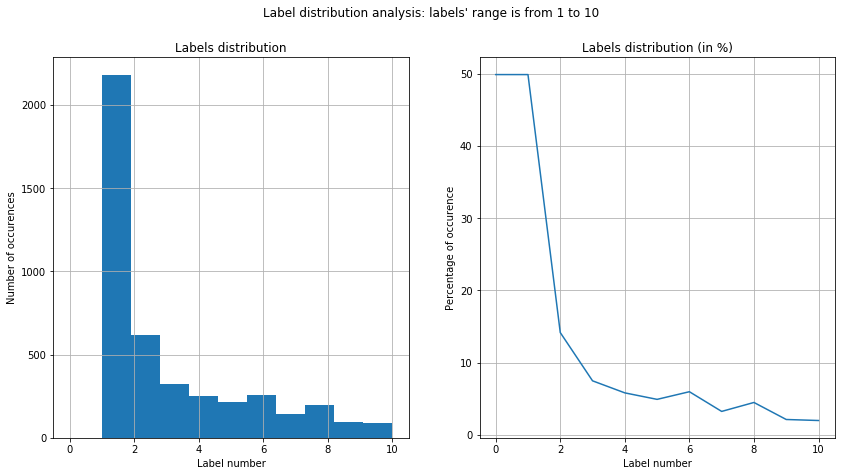

In [7]:
## Visualizes the labels
## Store the music genres that will be printed out
class_names = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
data = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(train_labels_accuracy == i)[0]) / len(train_labels_accuracy)) * 100, 2)}%')
    ## Since arrays are 0-indexed but the first label is 1, initialize the first position of the array using the first label (1)
    ## This is just to create a nice plot, does not have any effect on the algorithm.
    data[0, 0] = 0
    data[0, 1] = round((len(np.where(train_labels_accuracy == 1)[0]) / len(train_labels_accuracy)) * 100, 2)
    data[i, 0] = i
    data[i, 1] = round((len(np.where(train_labels_accuracy == i)[0]) / len(train_labels_accuracy)) * 100, 2)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.hist(train_labels_accuracy)
ax.set_title('Labels distribution')
ax.set_xlabel('Label number')
ax.set_ylabel('Number of occurences')
ax.grid(True)

ax = axs[1]
ax.plot(data[:, 1])
ax.set_title('Labels distribution (in %)')
ax.set_xlabel('Label number')
ax.set_ylabel('Percentage of occurence')
ax.grid(True)


fig.suptitle('Label distribution analysis: labels\' range is from 1 to 10')
plt.show()

### 2. Data manipulation
#### Cleanup
From the plots of the previous section it can be noticed that some columns (205 to 220) contains features whose values are not aligned with the others: so we can eliminate them.  
*Now each song has 248 features instead of 264.*

The difference in the data is easier to see by comparing the previous plot (re-plotted below) and the new plot.


**Note**: after various tests, it was discovered that eliminating the misaligned features had no practical effect on the whole algorithm: indeed, even though the overall accuracy of the model slightly decreased (from 75.83% to 75.43%) the accuracy with the new data (the test data) did not change. For this reason, we will use the complete dataset instead of the modified one.  
This is probably related to the fact the data are centered with mean 0 and standard variation 1, so the misaligned features do not have an high impact on the overall accuracy.

*Feel free to transform the following cell to a code cell to try the algorithms using the resized data set.*

**Note**: since this notebook utlizes scikit-learn tools, as suggested by their documentation it is important to scale the data.
Scaled data have two particular characteristics:
- Their mean is (almost) equal to 0
- Their variance is (almost) equal to 1  

Thus the data are centered around 0. The differences between the raw training data and the centered training data are visible in the plots below.  
By using the StandardScaler() function it is possible to apply the same transformation to both the datasets: training and testing.

The mean of the train data is: -3.9591392478315614e-17, the variance is: 0.9923953268977462
The mean of the test data is: -0.014540757008522483, the variance is: 1.0115121161980416


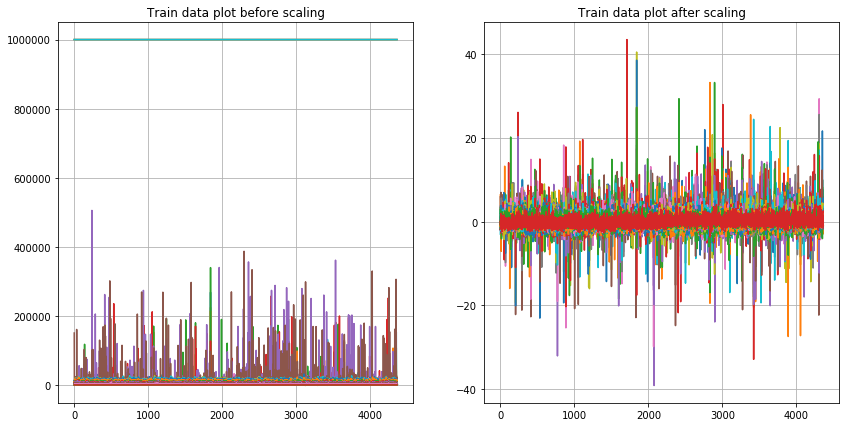

In [2]:
## Scales the data before feeding them into ML algorithms
scaler = preprocessing.StandardScaler().fit(train_data_accuracy)
train_data_scaled = scaler.transform(train_data_accuracy)   
test_data_scaled = scaler.transform(test_data_accuracy)                
print(f'The mean of the train data is: {np.mean(train_data_scaled)}, the variance is: {np.std(train_data_scaled)}')
print(f'The mean of the test data is: {np.mean(test_data_scaled)}, the variance is: {np.std(test_data_scaled)}')
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.plot(train_data_accuracy)
ax.set_title('Train data plot before scaling')
ax.grid(True)

ax = axs[1]
ax.plot(train_data_scaled)
ax.set_title('Train data plot after scaling')
ax.grid(True)

### 3. ML Algorithm
After data cleanup, it is time to implement the ML algorithms to predict the labels. For this purpose, this notebook uses *SVM - Support Vector Machine* and *RF - Random Forest*.
The notebook starts with the SVM, then the RF is implemented.  
It is important to notice that both algorithms use the same data.

#### Parameters choice and hyperparameters tuning
The following code is used to determine which are the best values for the parameters 'C', 'kernel' and 'gamma'.  
These parameters affect the accuracy of the algorithm: the best combination is chosen in order to maximize the accuracy upon the provided data.

**Important**: running the following cell require A LOT of time. The best set of parameters is reported in the next cell, so it is not necessary to run this cell again.

The following cell contains the parameters tuning algorithm: do not execute it!

In [ ]:
## Calculate the time needed for the following cell
start_time = time.time()
## Determine the best parameters for the Support Vector Algorithm
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':('scale', 'auto', 0.00001, 0.001, 0.0001)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, return_train_score=True, n_jobs = -1)
clf.fit(train_data_scaled, np.ravel(train_labels_accuracy))
end_time = time.time()
print(f'Total time needed for hyperparameters tuning: {end_time - start_time}')

#### Grid search results

In the following cell only a part of the data is displayed. The file output.csv contains all the data.

In [ ]:
print('Grid search results:')
df = pd.DataFrame(data=clf.cv_results_)
display(df)
df.to_csv('output.csv')
print('The best estimator is:')
print(clf.best_estimator_)

#### Best estimator:
The best estimator is:  
`SVC(C=3, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
 max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=True)`

#### Best parameters
The following cell contain the ML algorithm that uses the best set of parameters.

In [ ]:
## Once we have the best parameters for the estimator, we can start with the predictions
clf = svm.SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001)
clf.fit(train_data_scaled, np.ravel(train_labels_accuracy))

Calculate the accuracy of the algorithm

In [ ]:
score = clf.score(train_data_scaled, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

The following cell displays the result of the ML algorithm: the blue line represent the training labels and the red lines the predicted one. They should have a similar pattern, although if they are (almost) perfectly aligned, the model is probably overfitting.

In [ ]:
predictions = clf.predict(test_data_scaled)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    # Since arrays are 0-indexed but the first label is 1, initialize the first position of the array using the first label (1)
    # This is just to create a nice plot, does not have any effect on the algorithm.
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

The following cell is just a small utility function to save the predicted labels (contained in the pred array) to a csv file that follows the specification.

In [9]:
def save_prediction(pred, filename):
    prediction = pd.DataFrame(pred, columns=['Sample_label'])
    prediction.index += 1 
    prediction.to_csv(f'{filename}.csv',index_label="Sample_id",index=1)
    
save_prediction(predictions, 'SVM')

### RTF - Random Tree Forest

#### Tuning
As seen before, the following cell will (try to) optimize the hyperparameters of the Random Forest Algorithm.  
The best estimator found is in the next cell.  
*The following cell takes about 93 minutes on jupyterhub to compute.*

The following cell contains the parameters tuning algorithm: do not execute it!

In [ ]:
print('Grid search results:')
df = pd.DataFrame(data=rf_random.cv_results_)
display(df)
df.to_csv('output.csv')
print('The best estimator is:')
print(rf_random.best_params_)

The best estimator found is:  
`{'n_estimators': 717, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 97, 'bootstrap': True}`

In [3]:
## Plug in the best parameters found
rtf = RandomForestClassifier(criterion='gini', n_estimators=717, min_samples_split=5, min_samples_leaf=4, max_features=None, max_depth=97, bootstrap=True)
rtf.fit(train_data_accuracy, np.ravel(train_labels_accuracy))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=97, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=717, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [4]:
score = rtf.score(train_data_accuracy, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 94.55%


The following cell displays the result of the ML algorithm: the blue line represent the training labels and the red lines the predicted one.  
They should have a similar pattern, although if they are (almost) perfectly aligned, the model is probably overfitting.

Label 1 (Pop_Rock): 75.47%
Label 2 (Electronic): 11.43%
Label 3 (Rap): 7.79%
Label 4 (Jazz): 2.14%
Label 5 (Latin): 0.81%
Label 6 (RnB): 1.8%
Label 7 (International): 0.0%
Label 8 (Country): 0.15%
Label 9 (Reggae): 0.38%
Label 10 (Blues): 0.02%


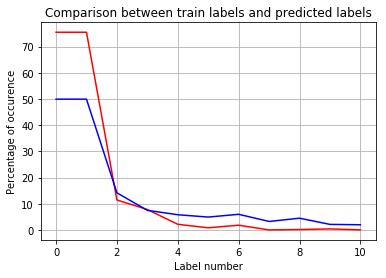

In [10]:
predictions = rtf.predict(test_data_accuracy)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

## Export the calculated predictions
save_prediction(predictions, 'Tree')

### Bonus content: Neural Network
In this last section about accuracy, the notebook contains the implementation of a Neural Network.  
The Neural Network uses the MLPClassifier function from scikit-learn tools: it is composed of two hidden layers of size ten each, plus one input and one output layer.  
The early stopping technique is used to prevent overfitting.
The algorithm tries to optimize the loss function in every epoch (maximum 1000) and stops when the loss does not improve more than 0.000001 for more than ten consecutive epochs.

In [ ]:
from sklearn.neural_network import MLPClassifier

#### Parameters tuning
The following cells evaluates which are the best parameters for the NN.

The best combination can be found below.

*Note*: running this cell takes a lot of time (more than 2 hours on my machine), so it is not advisable to run it. The correct parameters are already plugged in.

The following cell contains the parameters tuning algorithm: do not execute it!

In [ ]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:  
`{
    'activation': 'relu',
    'alpha': 0.0001,
    'early_stopping': True,
    'learning_rate': 'adaptive',
    'shuffle': False,
    'solver': 'adam'
}`

In [ ]:
mlp = MLPClassifier(activation='relu',
                    alpha=0.0001,
                    hidden_layer_sizes=(264, 264, 110),
                    learning_rate='constant',
                    max_iter=1000,
                    shuffle=False,
                    solver='adam',
                    tol=0.000001,
                    verbose=True,
                    early_stopping=True
                    )
mlp.fit(train_data_scaled, np.ravel(train_labels_accuracy))

In [ ]:
score = mlp.score(train_data_scaled, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

The following cell displays the result of the ML algorithm: the blue line represent the training labels and the red lines the predicted one.  
They should have a similar pattern, although if they are (almost) perfectly aligned, the model is probably overfitting.

In [ ]:
predictions = mlp.predict(test_data_scaled)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

save_prediction(predictions, 'NN')

## Log-loss
After the accuracy challenge, this section is focused on the log-loss challenge.  
Data visualization and manipulation sections are the same as above, so will not be commented.  

For the log-loss challenge only the SVM algorithm is presented, since the Neural Network did not perform well during tests: its loss on kaggle was 0.68353, thus around 6 times worse than the SVM. However, as in the other challenge, the two version of SVM are compared: with and without hyperparameters tuning.

### Contents
1. Data visualization: how are the raw data provided?
2. Data manipulation
3. ML Algorithm

In [11]:
# Libraries are already imported

# Loads the files
test_data_logloss = pd.read_csv('./log-loss/test_data.csv', header=None)
train_data_logloss = pd.read_csv('./log-loss/train_data.csv', header=None)
train_labels_logloss = pd.read_csv('./log-loss/train_labels.csv', header=None)

# Parse loaded content
test_data_logloss = test_data_logloss.values
train_data_logloss = train_data_logloss.values
train_labels_logloss = train_labels_logloss.values

### 1. Data visualization

In [ ]:
## Visualizes the training_data
plt.plot(train_data_logloss)
plt.title('Train data distribution')
plt.show()
# mean = np.mean(train_data_logloss, axis=0)
# std = np.std(train_data_logloss, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')
## Visualizes the test_data
plt.plot(test_data_logloss)
plt.title('Test data distribution')
plt.show()
# mean = np.mean(test_data_logloss, axis=0)
# std = np.std(test_data_logloss, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')

#### Observations
As we can see the training data nor the test data are normalized. In addition to it, labels are not equally distribuited: indeed there are more label of class 1 (almost 50%), Pop_Rock, then any other classes as we can see in the cell below. The figure below represents the occurence (in %) of each label.

Label 1 (Pop_Rock): 49.92%
Label 2 (Electronic): 14.16%
Label 3 (Rap): 7.47%
Label 4 (Jazz): 5.8%
Label 5 (Latin): 4.9%
Label 6 (RnB): 5.96%
Label 7 (International): 3.23%
Label 8 (Country): 4.47%
Label 9 (Reggae): 2.11%
Label 10 (Blues): 1.97%


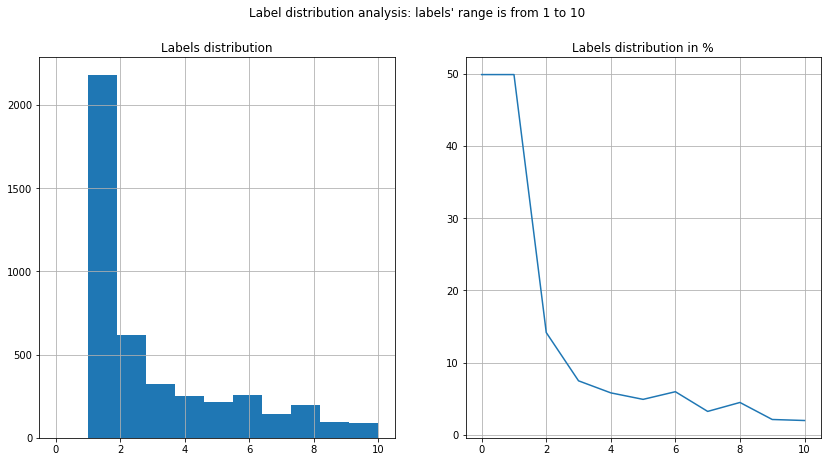

In [12]:
# Visualizes the labels
class_names = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
# Since labels start by 1, in the first position of the data array, I inserted again the value of the first label, to obtain a decent plot
data = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(train_labels_logloss == i)[0]) / len(train_labels_logloss)) * 100, 2)}%')
    data[0, 0] = 0
    data[0, 1] = round((len(np.where(train_labels_logloss == 1)[0]) / len(train_labels_logloss)) * 100, 2)
    data[i, 0] = i
    data[i, 1] = round((len(np.where(train_labels_logloss == i)[0]) / len(train_labels_logloss)) * 100, 2)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.hist(train_labels_logloss)
ax.set_title('Labels distribution')
ax.grid(True)

ax = axs[1]
ax.plot(data[:, 1])
ax.set_title('Labels distribution in %')
ax.grid(True)

fig.suptitle('Label distribution analysis: labels\' range is from 1 to 10')
plt.show()

### 2. Data manipulation

In [13]:
# Scales the data before feeding them into ML algorithms
scaler = preprocessing.StandardScaler().fit(train_data_logloss)
train_data_scaled = scaler.transform(train_data_logloss)   
test_data_scaled = scaler.transform(test_data_logloss)                
print(f'The mean of the train data is: {np.mean(train_data_scaled)}, the variance is {np.std(train_data_scaled)}')
print(f'The mean of the test data is: {np.mean(test_data_scaled)}, the variance is {np.std(test_data_scaled)}')

The mean of the train data is: -3.9591392478315614e-17, the variance is 0.9923953268977462
The mean of the test data is: -0.014540757008522483, the variance is 1.0115121161980416


### 3. ML Algorithm
After data cleanup, the algorithm used for the predictions is presented: this notebook uses the SVM - Support Vector Machine - to predict the labels.

The following cell contains the parameters tuning algorithm: do not execute it!

In [ ]:
## Calculate the time needed for the following cell
start_time = time.time()
## Determine the best parameters for the Support Vector Algorithm
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':('scale', 'auto')}
svc = svm.SVC(probability=True)
clf = GridSearchCV(svc, parameters, cv=5, return_train_score=True, n_jobs = -1)
clf.fit(train_data_scaled, np.ravel(train_labels_accuracy))
end_time = time.time()
print(f'Total time needed for hyperparameters tuning: {end_time - start_time}')

In [ ]:
clf = svm.SVC(C=3, gamma='scale', verbose=True, probability=True)
clf.fit(train_data_scaled, np.ravel(train_labels_logloss))

In [ ]:
score = clf.score(train_data_scaled, train_labels_logloss)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

In [ ]:
predictions = clf.predict_proba(test_data_scaled)
assert predictions.shape == (6544, 10)

data_l = np.empty((1, 10))
for i in range(predictions.shape[1]):
    data_l[0, i] = np.mean(predictions[:, i]) * 100
    print(f'Average probability for label {i + 1} ({class_names[i]}): {np.round(data_l[0, i], 2)}%')

plt.plot(data_l[0, :], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.xlabel('Label number')
plt.ylabel('Percentage of occurence')
plt.show()

In [ ]:
def save_prediction_loss(loss):
    prediction = pd.DataFrame(loss,columns=['Class_1','Class_2','Class_3','Class_4','Class_5',
                                            'Class_6','Class_7','Class_8','Class_9','Class_10'])
    prediction.index += 1 
    prediction.to_csv('loss_kaggle.csv',index_label="Sample_id",index=1)
    
save_prediction_loss(predictions)

## 4. Results

These are the various results obtained on kaggle:  
### Accuracy challenge
- SVM with hyperparameter tuning: 0.65715
- SVM without hyperparameter tuning: 0.64034
- RF with hyperparameter tuning: 0.61691
- RF without hyperparameter tuning: 0.64034
- NN with hyperparameter tuning: 0.62608
- NN without hyperparameter tuning: 0.63728

### Logloss challenge
- SVM with hyperparameter tuning: 
- SVM without hyperparameter tuning: 0.16922 

## 5. Discussion/Conclusions

This paper analyzed different approaches to the same problem: music genre classification. 
The most accurate algorithm was the Support Vector Machine with hyperparameters tuning: it was possible to achieve an'accuracy of 65.71% on the test data.  
Random Forest Tree algorithm instead performed quite well without any kind of tuning (64.03%), but became less accurate once its parameters were optimized.  
For parameters optimization two different approaches were used:
1. GridSearchCV
2. RandomizedSearchCV  

These two strategies apply the same algorithm in two different methods:  
GridSearchCV evaluates the accuracy and other statistics of a ML methods trying all the possible combination of parameters. For this reason, it is more computational expensive and takes a longer time.  

RandomizedSearchCV on the other hand, operates by choosing random combinations of parameters and picking the best one. This method is faster since it needs less iterations to be performed, but sometimes is less accurate.  

GridSearchCV was used to tune the SVM estimator, since it has less parameters and it was possible to compute the best estimator in a relatively small amount of time (less than 2 hours).  

RandomizedSearchCV was instead used to tune the parameters of RT because it contains more paramenters and thus more possible combination. Indeed, applying the GridSearchCV resulted in having to evaluate more than 25 thousand score. While using the random version it was possible to evaluate only 50 fits.

Even the Neural Network did not benefit from the hyperparameters tuning.  

The ineffettivity of the tuning for Random Tree Forest and for the Neural Network might be caused by the fact that, while for SVM is possible to test more parameters that have some fixed values (for example gamma is usually a value less than 1 or is 'auto' or 'scale'), the tree and the Neural Network both heavily rely on the number of the estimators (for the tree) or layers (and perceptrons per layer) (for the Neural Network): so it is more difficult to find the best combination.

## 6. References

Below are reported all the references used throughout the notebook.   
However, instead of using the standard IEEE reference style, the references were put inline in the text for an easier and faster access.  

Wikipedia, https://en.wikipedia.org/wiki/Support_vector_machine  
Wikipedia, https://en.wikipedia.org/wiki/Random_forest
